# 🚙 Automotive: Estimating Car Prices for a Local Dealership

# 📦 Import Libraries

In [ ]:
!pip install setuptools

In [1]:
!pip install --upgrade pip  --quiet

In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install ppscore==1.3.0

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

import pickle
import os

# 📂 Load Dataset

In [2]:
cars = pd.read_csv("cars.csv")
cars.head()

,make,model,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment
0,mazda,2,5500,2008,with mileage,162000.0,petrol,1500.0,burgundy,mechanics,front-wheel drive,B
1,mazda,2,5350,2009,with mileage,120000.0,petrol,1300.0,black,mechanics,front-wheel drive,B
2,mazda,2,7000,2009,with mileage,61000.0,petrol,1500.0,silver,auto,front-wheel drive,B
3,mazda,2,3300,2003,with mileage,265000.0,diesel,1400.0,white,mechanics,front-wheel drive,B
4,mazda,2,5200,2008,with mileage,97183.0,diesel,1400.0,gray,mechanics,front-wheel drive,B


# 🧹 Data Cleaning

In [3]:
cars.info()
cars.describe()

cars.drop_duplicates(inplace=True)

cars = cars.dropna(subset=['priceUSD', 'year', 'mileage(kilometers)'])
cars['segment'].fillna("Unknown", inplace=True)

cars['condition'] = cars['condition'].str.lower().str.strip()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56244 entries, 0 to 56243
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   make                 56244 non-null  object 
 1   model                56244 non-null  object 
 2   priceUSD             56244 non-null  int64  
 3   year                 56244 non-null  int64  
 4   condition            56244 non-null  object 
 5   mileage(kilometers)  56244 non-null  float64
 6   fuel_type            56244 non-null  object 
 7   volume(cm3)          56197 non-null  float64
 8   color                56244 non-null  object 
 9   transmission         56244 non-null  object 
 10  drive_unit           54339 non-null  object 
 11  segment              50953 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 5.1+ MB


# 🚗 Feature Engineering

### Feature Engineering: Car Age

In [4]:
cars['car_age'] = 2019 - cars['year']

### Feature Engineering: Brand Premium/Discount

In [5]:
average_price_by_make = cars.groupby('make')['priceUSD'].mean()

overall_average_price = cars['priceUSD'].mean()

cars['brand_premium_discount'] = cars['make'].map(average_price_by_make) - overall_average_price

print("First 5 rows with 'brand_premium_discount':")
display(cars[['make', 'priceUSD', 'brand_premium_discount']].head())

First 5 rows with 'brand_premium_discount':


,make,priceUSD,brand_premium_discount
0,mazda,5500,-2432.946626
1,mazda,5350,-2432.946626
2,mazda,7000,-2432.946626
3,mazda,3300,-2432.946626
4,mazda,5200,-2432.946626


### Feature Engineering: Mileage per Year

In [6]:
cars['mileage_per_year'] = cars['mileage(kilometers)'] / (cars['car_age'] + 1e-6)

print("\nFirst 5 rows with 'mileage_per_year':")
display(cars[['mileage(kilometers)', 'car_age', 'mileage_per_year']].head())


First 5 rows with 'mileage_per_year':


,mileage(kilometers),car_age,mileage_per_year
0,162000.0,11,14727.271388
1,120000.0,10,11999.998800
2,61000.0,10,6099.999390
3,265000.0,16,16562.498965
4,97183.0,11,8834.817379


### Feature Engineering: Segment Value Index

In [7]:
average_price_by_segment = cars.groupby('segment')['priceUSD'].mean()

cars['segment_value_index'] = cars['segment'].map(average_price_by_segment) - overall_average_price

print("\nFirst 5 rows with 'segment_value_index':")
display(cars[['segment', 'priceUSD', 'segment_value_index']].head())


First 5 rows with 'segment_value_index':


,segment,priceUSD,segment_value_index
0,B,5500,-3128.395207
1,B,5350,-3128.395207
2,B,7000,-3128.395207
3,B,3300,-3128.395207
4,B,5200,-3128.395207


### Feature Engineering: Make-Model Combination

In [8]:
cars['make_model'] = cars['make'] + '_' + cars['model']

print("\nFirst 5 rows with 'make_model':")
display(cars[['make', 'model', 'make_model']].head())


First 5 rows with 'make_model':


,make,model,make_model
0,mazda,2,mazda_2
1,mazda,2,mazda_2
2,mazda,2,mazda_2
3,mazda,2,mazda_2
4,mazda,2,mazda_2


### Feature Engineering: Extract Relevant Data Per make

In [9]:
# Extract relevant data per make: calculate price statistics for each make
make_price_stats = cars.groupby('make')['priceUSD'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()

print("Price statistics per make:")
display(make_price_stats.head())

Price statistics per make:


,make,mean,median,std,min,max
0,acura,11991.765306,10750.0,6630.499429,2700,31900
1,alfa-romeo,2691.052863,2150.0,2221.726957,245,18000
2,aro,2950.000000,2950.0,70.710678,2900,3000
3,asia,7000.000000,7000.0,NaN,7000,7000
4,aston-martin,95000.000000,95000.0,NaN,95000,95000


In [10]:
make_stats_for_clustering = make_price_stats[['mean', 'median', 'std', 'min', 'max']]

make_stats_for_clustering = make_stats_for_clustering.fillna(make_stats_for_clustering.mean())

scaler = StandardScaler()
scaled_make_stats = scaler.fit_transform(make_stats_for_clustering)

print("Scaled price statistics for clustering (first 5 rows):")
display(pd.DataFrame(scaled_make_stats, columns=make_stats_for_clustering.columns).head())

Scaled price statistics for clustering (first 5 rows):


,mean,median,std,min,max
0,0.027852,0.005626,0.040023,-0.139901,-0.111455
1,-0.406480,-0.362704,-0.442878,-0.292220,-0.426835
2,-0.394388,-0.328441,-0.678483,-0.127492,-0.767174
3,-0.205258,-0.154983,0.000000,0.126892,-0.676417
4,3.904238,3.613977,0.000000,5.586829,1.320236


Clustering complete with 4 clusters.

First 5 rows of make_price_stats with cluster assignments:


,make,mean,median,std,min,max,cluster
0,acura,11991.765306,10750.0,6630.499429,2700,31900,0
1,alfa-romeo,2691.052863,2150.0,2221.726957,245,18000,0
2,aro,2950.000000,2950.0,70.710678,2900,3000,0
3,asia,7000.000000,7000.0,NaN,7000,7000,0
4,aston-martin,95000.000000,95000.0,NaN,95000,95000,1


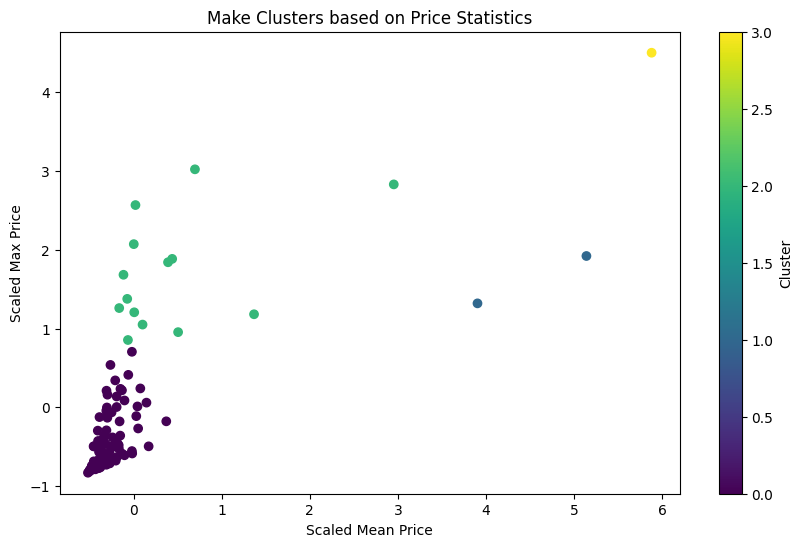

In [11]:
# Choose the number of clusters (you can experiment with this)
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # Added n_init for robustness
make_price_stats['cluster'] = kmeans.fit_predict(scaled_make_stats)

print(f"Clustering complete with {n_clusters} clusters.")
print("\nFirst 5 rows of make_price_stats with cluster assignments:")
display(make_price_stats.head())

plt.figure(figsize=(10, 6))
plt.scatter(scaled_make_stats[:, 0], scaled_make_stats[:, 4], c=make_price_stats['cluster'], cmap='viridis')
plt.xlabel('Scaled Mean Price')
plt.ylabel('Scaled Max Price')
plt.title('Make Clusters based on Price Statistics')
plt.colorbar(label='Cluster')
plt.show()

In [12]:
make_to_cluster = make_price_stats.set_index('make')['cluster'].to_dict()

cars['make_price_cluster'] = cars['make'].map(make_to_cluster)

print("First 5 rows of cars with the new 'make_price_cluster' feature:")
display(cars[['make', 'priceUSD', 'make_price_cluster']].head())

First 5 rows of cars with the new 'make_price_cluster' feature:


,make,priceUSD,make_price_cluster
0,mazda,5500,0
1,mazda,5350,0
2,mazda,7000,0
3,mazda,3300,0
4,mazda,5200,0


In [13]:
cars.isnull().sum()

make                         0
model                        0
priceUSD                     0
year                         0
condition                    0
mileage(kilometers)          0
fuel_type                    0
volume(cm3)                 47
color                        0
transmission                 0
drive_unit                1904
segment                      0
car_age                      0
brand_premium_discount       0
mileage_per_year             0
segment_value_index          0
make_model                   0
make_price_cluster           0
dtype: int64

In [14]:
cars.drop(columns=['year'], inplace=True)

<Axes: >

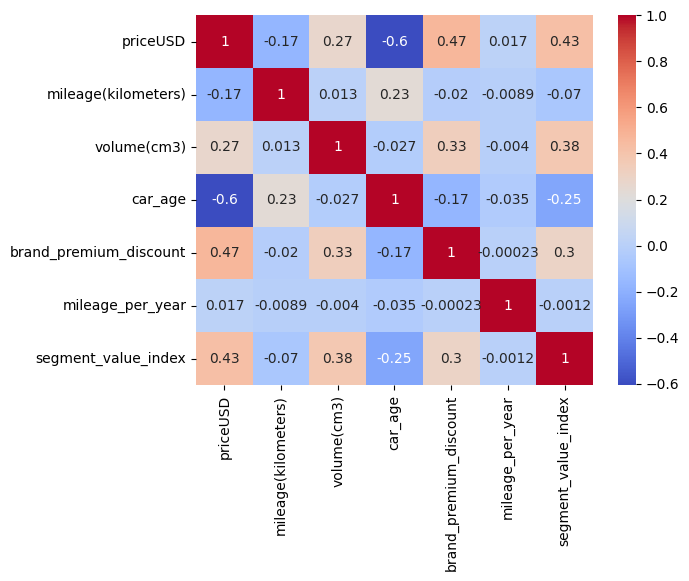

In [15]:
numerics = ['priceUSD', 'mileage(kilometers)', 'volume(cm3)', 'car_age', 'brand_premium_discount', 'mileage_per_year', 'segment_value_index']
sns.heatmap(cars[numerics].corr(), annot=True, cmap="coolwarm")

## Correlation Heatmap Analysis

The heatmap above shows the Pearson correlation coefficients between key numerical features in the dataset:

- **Strongest Correlations:**
  - `priceUSD` and `car_age`: There is a strong negative correlation (-0.60), indicating that as cars get older, their price tends to decrease significantly.
  - `priceUSD` and `brand_premium_discount` (0.47): Cars from brands with a higher premium tend to have higher prices.
  - `priceUSD` and `segment_value_index` (0.43): Cars in higher-value segments are priced higher on average.
  - `priceUSD` and `volume(cm3)` (0.27): Larger engine volumes are moderately associated with higher prices.

- **Other Notable Relationships:**
  - `car_age` and `mileage(kilometers)` (0.23): Older cars generally have higher mileage, as expected.
  - `volume(cm3)` and `brand_premium_discount` (0.33): Premium brands tend to offer cars with larger engines.
  - `volume(cm3)` and `segment_value_index` (0.38): Higher segment value is associated with larger engine sizes.

- **Weak or No Correlation:**
  - `mileage_per_year` shows almost no correlation with `priceUSD` or other features, suggesting that annual mileage alone is not a strong predictor of price in this dataset.
  - Some features, such as `mileage(kilometers)` and `brand_premium_discount`, are nearly uncorrelated.

**Business Insight:**  
The strongest predictors of car price are car age, brand premium/discount, and segment value index. These engineered features capture important market effects and justify their inclusion in the modeling process. Weak correlations between some features suggest low risk of multicollinearity, but also highlight that some variables may not add much predictive value on their own.

**Conclusion:**  
This correlation analysis helps prioritize features for modeling and provides transparency for business stakeholders about which factors most influence car

# 📊 Exploratory Data Analysis

## Predictive Power Score (PPS) Analysis

The Predictive Power Score (PPS) is an asymmetric, data-driven score that ranges from 0 to 1 and indicates how well one variable can predict another variable. It can be a useful alternative or complement to correlation analysis, especially for non-linear relationships.

In [16]:
pps_score_example = pps.score(cars, "car_age", "priceUSD")

print(f"PPS score of 'car_age' predicting 'priceUSD':\n")
display(pps_score_example)

PPS score of 'car_age' predicting 'priceUSD':



{'x': 'car_age',
 'y': 'priceUSD',
 'ppscore': 0.40019674958892537,
 'case': 'regression',
 'is_valid_score': True,
 'metric': 'mean absolute error',
 'baseline_score': 4742.2834,
 'model_score': 2844.4369976904827,
 'model': DecisionTreeRegressor()}

In [17]:
pps_matrix = pps.matrix(cars)

print("Predictive Power Score (PPS) Matrix:")
display(pps_matrix)

Predictive Power Score (PPS) Matrix:


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,make,make,1.000000,predict_itself,True,None,0.000000e+00,1.000000e+00,None
1,make,model,0.120957,classification,True,weighted F1,6.800000e-03,1.269341e-01,DecisionTreeClassifier()
2,make,priceUSD,0.047640,regression,True,mean absolute error,4.742283e+03,4.516363e+03,DecisionTreeRegressor()
3,make,condition,0.000000,classification,True,weighted F1,9.760645e-01,9.759645e-01,DecisionTreeClassifier()
4,make,mileage(kilometers),0.023384,regression,True,mean absolute error,1.174573e+05,1.147107e+05,DecisionTreeRegressor()
...,...,...,...,...,...,...,...,...,...
284,make_price_cluster,brand_premium_discount,0.364881,regression,True,mean absolute error,2.469581e+03,1.568478e+03,DecisionTreeRegressor()
285,make_price_cluster,mileage_per_year,0.000000,regression,True,mean absolute error,2.591234e+07,5.170819e+07,DecisionTreeRegressor()
286,make_price_cluster,segment_value_index,0.000000,regression,True,mean absolute error,2.423007e+03,2.731432e+03,DecisionTreeRegressor()
287,make_price_cluster,make_model,0.000705,classification,True,weighted F1,6.800000e-03,7.500260e-03,DecisionTreeClassifier()


In [19]:
pps_price_after = pps_matrix[pps_matrix['y'] == 'priceUSD'].copy()

weak_thresh = 0.005
weak_feats = pps_price_after.loc[pps_price_after['ppscore'] < weak_thresh, 'x'].tolist()

do_not_drop = set(['priceUSD','car_age','mileage_per_year','make_price_cluster'])
weak_feats = [f for f in weak_feats if f not in do_not_drop and f in cars.columns] # Use 'cars' DataFrame for column check

df_model = cars.drop(columns=weak_feats)
print(f"Dropped {len(weak_feats)} weak features")

print("Dropped columns:")
for col in sorted(weak_feats):
    print("-", col)

Dropped 2 weak features
Dropped columns:
- condition
- fuel_type


## Feature plots

Text(0.5, 1.0, 'Price Distribution')

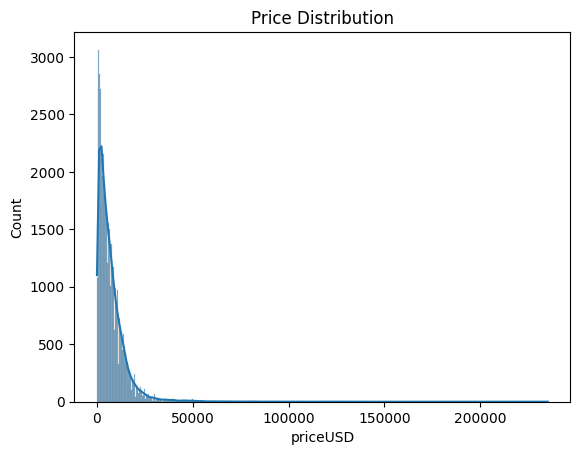

In [20]:
sns.histplot(cars['priceUSD'], kde=True)
plt.title('Price Distribution')

The distribution of car prices is **highly right-skewed** with most vehicles priced below **20,000** and a long tail of high priced luxury cars. This skew can negatively impact certain regression models, so a **log transformation** so a **log transformation** (e.g., capping extreme prices) may improve predictive performance. Luxury cars (>$100,000) form only a small portion of the dataset and could be treated as outliers for modeling purposes.

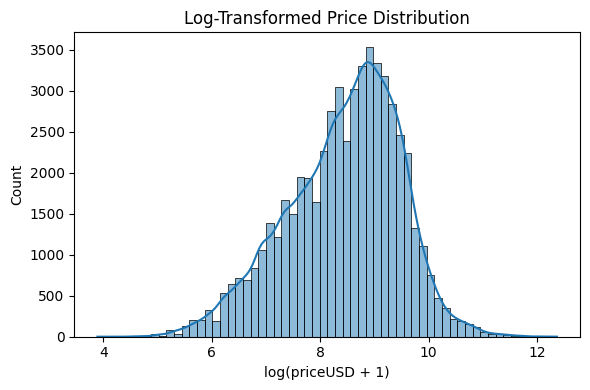

In [21]:
cars['log_priceUSD'] = np.log1p(cars['priceUSD'])

plt.figure(figsize=(6, 4))
sns.histplot(cars['log_priceUSD'], bins=60, kde=True)
plt.title("Log-Transformed Price Distribution")
plt.xlabel("log(priceUSD + 1)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

The original `priceUSD` variable is highly skewed, with most cars priced below $20,000 and a few luxury vehicles priced far higher. To normalize the distribution and reduce the effect of extreme outliers, we applied a **log1p transformation** (`log(priceUSD + 1)`).

This results in a smoother, more bell-shaped distribution, which can improve model performance.

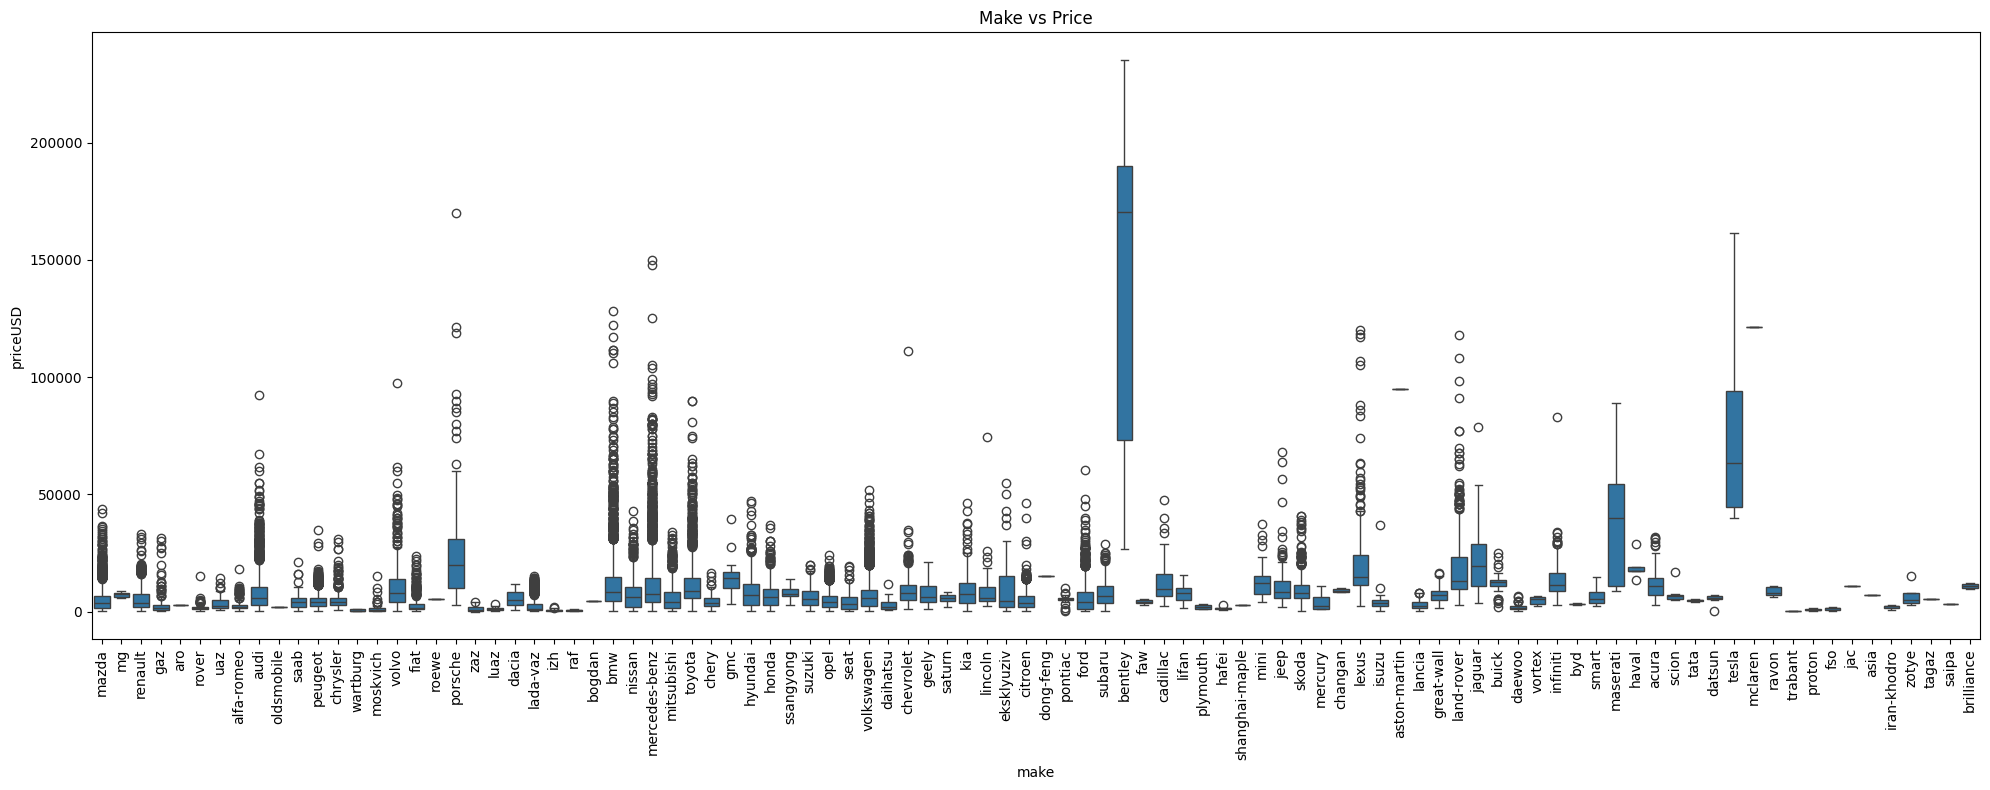

In [22]:
# Brand influence
plt.figure(figsize=(20,8)) # Increased figure size
sns.boxplot(x='make', y='priceUSD', data=cars)
plt.xticks(rotation=90) # Increased rotation angle
plt.title('Make vs Price')
plt.tight_layout() # Adjust layout to prevent labels from overlapping

## Analysis: Make vs Price Boxplot

The boxplot above visualizes the distribution of car prices (`priceUSD`) for each car make in the dataset. Here’s what we can observe:

- **Brand Price Ranges:**  
  Some brands (e.g., Bentley, Porsche, Tesla) have much higher median prices and wider price ranges, indicating they are luxury brands with both high base prices and expensive models. In contrast, brands like Dacia, Daewoo, and Lada-Vaz have lower and more consistent prices, reflecting their economy market positioning.

- **Outliers:**  
  Many brands show significant outliers (dots above the boxes), representing rare, high-priced models or possibly data entry errors. This highlights the importance of handling outliers in price modeling.

- **Price Consistency:**  
  Brands with narrow boxes (e.g., Dacia, Daewoo) have consistent pricing, while those with wide boxes (e.g., Mercedes-Benz, BMW) offer a broader range of models and prices.

- **Business Insight:**  
  Understanding these price distributions helps dealerships identify which brands offer more stable pricing and which have greater variability. This can inform inventory decisions and pricing strategies.

**Conclusion:**  
This plot is a valuable part of exploratory data analysis (EDA). It helps you understand the diversity of the dataset, spot outliers, and justify feature engineering steps (such as creating a "luxury brand" indicator or handling outliers). While not strictly required for modeling, it provides important context for both data scientists and business stakeholders.

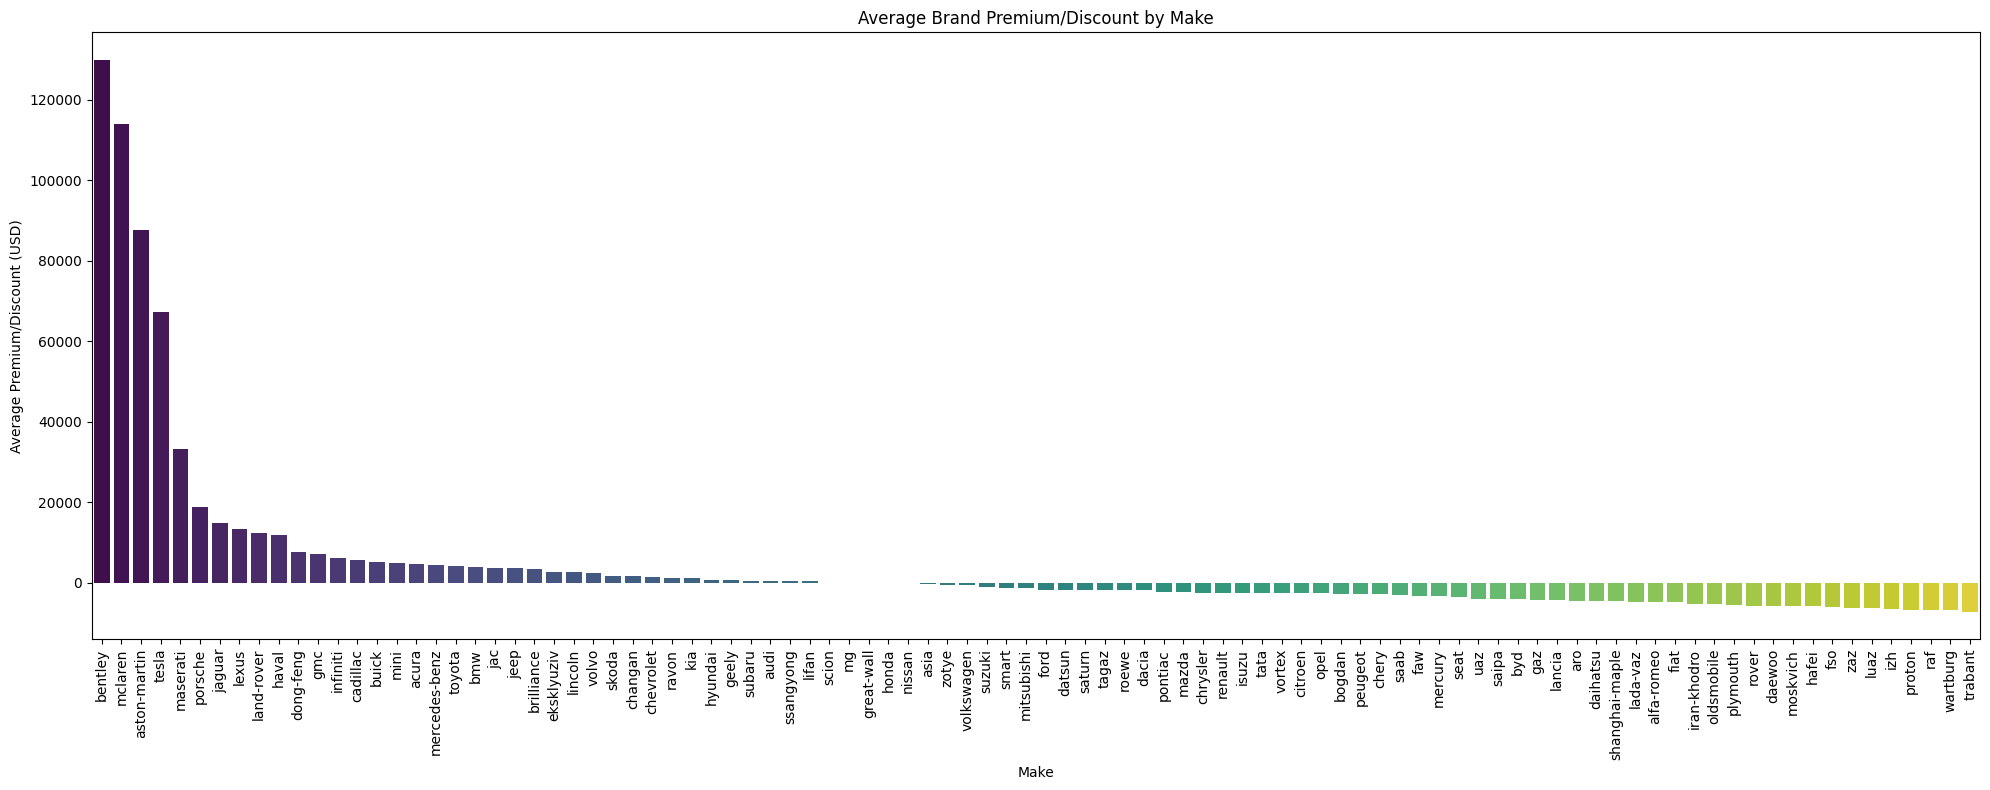

In [42]:
# Calculate the average brand_premium_discount for each make
average_brand_premium = cars.groupby('make')['brand_premium_discount'].mean().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(20, 8))
sns.barplot(x=average_brand_premium.index, y=average_brand_premium.values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Average Brand Premium/Discount by Make')
plt.xlabel('Make')
plt.ylabel('Average Premium/Discount (USD)')
plt.tight_layout()
plt.show()

## Analysis: Average Brand Premium/Discount by Make

The bar plot above shows the average brand premium or discount for each car make, relative to the overall average price in the dataset.

- **Luxury Brands:**  
  Brands like Bentley, McLaren, Aston Martin, Tesla, and Maserati have the highest average premiums, meaning their cars are priced well above the dataset average. These are luxury or high-performance brands.

- **Mainstream Brands:**  
  Brands near the center (e.g., Toyota, Ford, Hyundai) have average premiums or discounts close to zero, indicating their prices are near the overall market average.

- **Economy Brands:**  
  Brands on the far right (e.g., Trabant, Wartburg, FSO, Lada-Vaz, Dacia) have the largest discounts, meaning their cars are priced well below the dataset average. These are typically economy or budget brands.

- **Business Insight:**  
  This visualization helps dealerships quickly identify which brands command a premium and which are typically discounted. This can inform inventory, pricing, and marketing strategies.

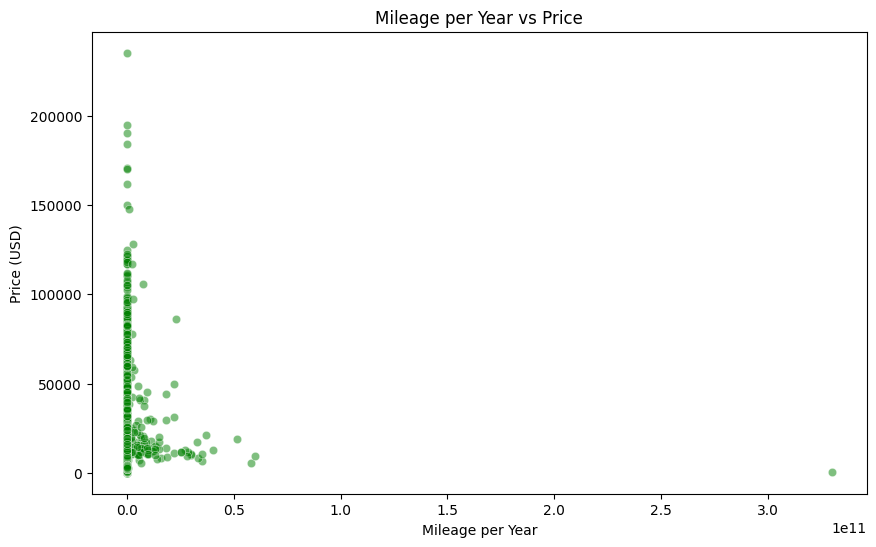

In [43]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=cars['mileage_per_year'], y=cars['priceUSD'], alpha=0.5, color='green') # Use scatterplot and specify color
plt.title('Mileage per Year vs Price') # Updated title
plt.xlabel('Mileage per Year')
plt.ylabel('Price (USD)') # Updated ylabel
plt.show()

## Analysis: Mileage per Year vs Price

The scatter plot above shows the relationship between a car's **mileage per year** and its **price (USD)**.

- **Negative Correlation:**  
  There is a clear negative relationship: as mileage per year increases, car price tends to decrease. Cars with very high mileage per year are generally valued much lower.

- **Outliers:**  
  A few cars have extremely high mileage per year, which may be due to data entry errors or rare use cases. These outliers can distort the analysis and may need to be investigated or removed.

- **Business Insight:**  
  Mileage per year is a strong indicator of car value. Dealerships should pay close attention to this metric when pricing used vehicles, as buyers typically prefer cars with lower annual mileage.

**Is this plot necessary?**  
Yes, this plot is useful for exploratory data analysis (EDA). It visually confirms the importance of mileage per year as a predictive feature and helps justify its inclusion in the model. It also highlights potential data quality issues (outliers) that should be

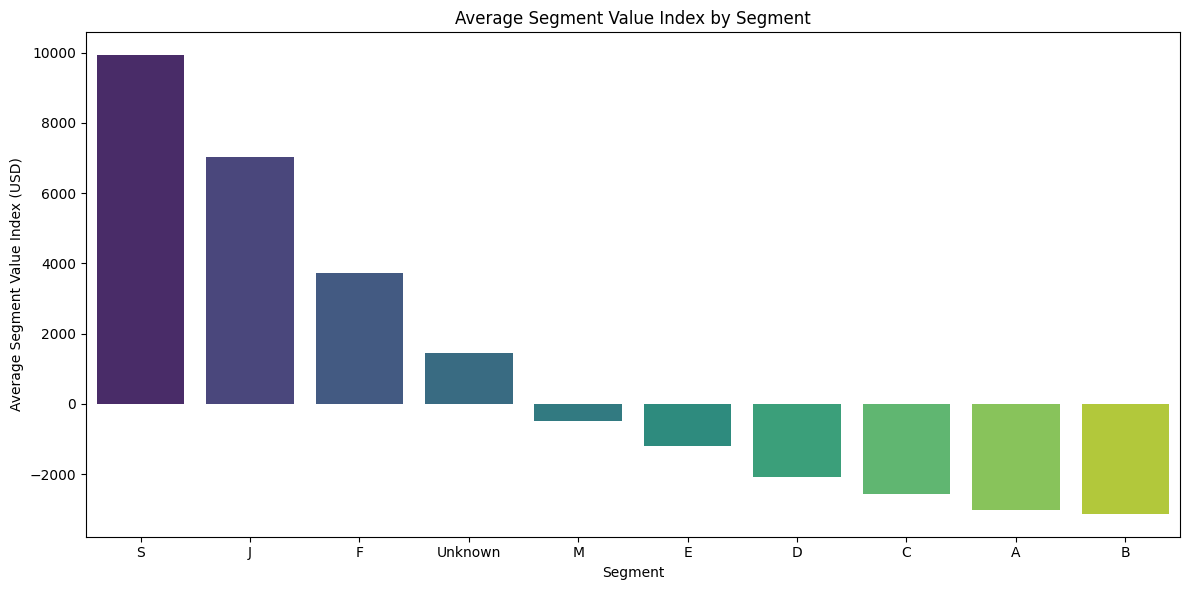

In [44]:
average_segment_value = cars.groupby('segment')['segment_value_index'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=average_segment_value.index, y=average_segment_value.values, palette='viridis')
plt.title('Average Segment Value Index by Segment')
plt.xlabel('Segment')
plt.ylabel('Average Segment Value Index (USD)')
plt.tight_layout()
plt.show()

## Analysis: Average Segment Value Index by Segment

The bar plot above displays the average segment value index for each car segment, relative to the overall average price in the dataset.

- **High-Value Segments:**  
  Segments such as S (Sport), J (SUV), and F (Luxury) have the highest average segment value indexes, indicating that cars in these segments are typically priced well above the overall market average.

- **Mid/Unknown Segments:**  
  The "Unknown" and M (Multi-purpose) segments are close to the average, with only a slight premium or discount.

- **Low-Value Segments:**  
  Segments B, A, C, and D (typically economy, compact, and small cars) have the largest negative value indexes, meaning these cars are priced well below the dataset average.

- **Business Insight:**  
  This visualization helps dealerships understand which car segments command a premium and which are generally discounted. This can guide inventory decisions, marketing strategies, and pricing policies.

**Is this plot necessary?**  
Yes, this plot is valuable for exploratory data analysis (EDA). It provides insight into how different car segments are valued in the market, justifies the use of the `segment_value_index` feature, and supports business decisions regarding which segments to focus on.

# 💡Prepare Data for Modeling

In [26]:
X = cars.drop("priceUSD", axis=1)
y = cars["priceUSD"]

In [27]:
numeric_features = ['mileage(kilometers)', 'volume(cm3)', 'car_age', 'brand_premium_discount', 'mileage_per_year', 'segment_value_index']

# Add 'make_price_cluster' to the categorical features
categorical_features = list(set(X.columns) - set(numeric_features))
categorical_features.append('make_price_cluster')

# Remove 'make' and 'model' since 'make_model' and 'make_price_cluster' cover this
categorical_features = [f for f in categorical_features if f not in ['make', 'model']]

In [24]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 🧠 Model Training & Evaluation

In [28]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror')
}

results = []

# Add imputer to the pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Use log_priceUSD as the target variable
X = cars.drop("priceUSD", axis=1)
y = cars["log_priceUSD"] # Changed target to log_priceUSD

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


for name, model in models.items():
    pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                               ("regressor", model)])

    pipeline.fit(X_train, y_train)
    log_preds = pipeline.predict(X_test)

    preds = np.expm1(log_preds)

    y_test_original = cars.loc[y_test.index, 'priceUSD']

    mae = mean_absolute_error(y_test_original, preds)
    rmse = np.sqrt(mean_squared_error(y_test_original, preds))
    r2 = r2_score(y_test_original, preds)

    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})

pd.DataFrame(results).sort_values("RMSE")

,Model,MAE,RMSE,R2
4,Random Forest,916.516414,2629.724458,0.896965
6,XGBoost,1163.109075,2813.572446,0.882055
3,Decision Tree,1120.221866,3162.017793,0.851032
5,Gradient Boosting,1451.395041,3590.472138,0.807927
1,Ridge,977.082362,4024.988361,0.758625
0,Linear Regression,457.228027,4642.345093,0.678902
2,Lasso,4931.607810,8660.547678,-0.117516


# 🔍 Identify the best model




In [29]:
results_df = pd.DataFrame(results).sort_values("RMSE")
best_model_result = results_df.iloc[0]
display(best_model_result)

Model    Random Forest
MAE         916.516414
RMSE       2629.724458
R2            0.896965
Name: 4, dtype: object


# 🔬 Hyperparameter Tuning

In [32]:
param_grid_rf = {
    'regressor__n_estimators': [100, 200], # Number of trees in the forest
    'regressor__max_depth': [None, 10], # Maximum depth of the tree
    'regressor__min_samples_split': [2, 5], # Minimum number of samples required to split an internal node
    'regressor__min_samples_leaf': [1, 2] # Minimum number of samples required to be at a leaf node
}

pipeline_rf = Pipeline(steps=[("preprocessor", preprocessor),
                              ("regressor", RandomForestRegressor(random_state=42))])

grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

grid_rf.fit(X_train, y_train)

print("Best Params:", grid_rf.best_params_)
print("Best Score (MAE):", -grid_rf.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


Python(8835) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8836) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8837) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8838) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8839) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8840) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8841) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8842) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best Params: {'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Best Score (MAE): 0.1480024611462909


# 🧠 Train the final model



In [33]:
best_params = grid_rf.best_params_

regressor_params = {key.replace('regressor__', ''): value for key, value in best_params.items()}

final_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **regressor_params)

final_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                 ("regressor", final_model)])

final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['mileage(kilometers)',
                                                   'volume(cm3)', 'car_age',
                                                   'brand_premium_discount',
                                                   'mileage_per_year',
                                                   'segment_value_index']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHo...
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, min_samples_leaf=1,
                              min_samples_split=2, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, ...))])

# 📝 Make predictions

In [34]:
final_predictions = final_pipeline.predict(X_test)

In [35]:
test_results = X_test.copy()
test_results['actual_price'] = y_test
test_results['predicted_price'] = final_predictions
test_results['price_residual'] = test_results['actual_price'] - test_results['predicted_price']

print("First 5 rows with 'actual_price', 'predicted_price', and 'price_residual':")
display(test_results[['actual_price', 'predicted_price', 'price_residual']].head())

First 5 rows with 'actual_price', 'predicted_price', and 'price_residual':


,actual_price,predicted_price,price_residual
3077,8.366603,8.134212,0.232390
21687,9.901035,9.728189,0.172845
224,9.392745,9.266951,0.125795
12282,9.179984,9.097558,0.082426
28622,9.071193,8.916248,0.154945


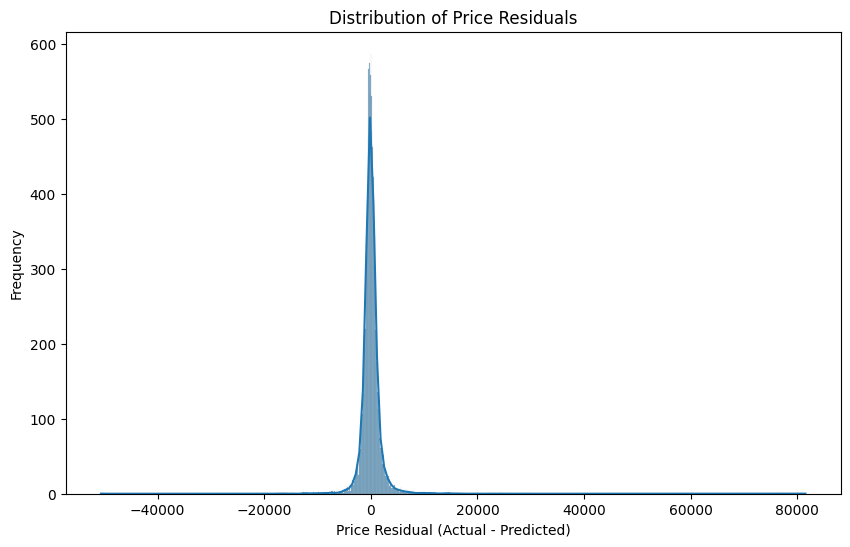

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(test_results['price_residual'], kde=True)
plt.title('Distribution of Price Residuals')
plt.xlabel('Price Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

The residual distribution is sharply centered around zero, indicating the model is generally unbiased in its predictions. Most predictions are close to the actual car prices, but there are some large errors on both sides (heavy tails). These outliers suggest certain cars in the dataset are difficult to predict accurately, potentially due to missing variables or extreme values.

### Identifying Undervalued Cars (Largest Negative Residuals)

These are the cars where the actual price was significantly lower than the predicted price by the model.

In [36]:
print("Top 10 Potentially Undervalued Cars:")
display(test_results.sort_values('price_residual').head(5))

Top 10 Potentially Undervalued Cars:


,make,model,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment,car_age,brand_premium_discount,mileage_per_year,segment_value_index,make_model,make_price_cluster,log_priceUSD,actual_price,predicted_price,price_residual
42345,chery,qq,for parts,170000.0,petrol,1100.0,red,mechanics,front-wheel drive,Unknown,11,-2869.194107,15454.544050,1443.063624,chery_qq,0,5.062595,5.062595,7.680021,-2.617426
6223,lada-vaz,2106,with mileage,8685.0,petrol,1500.0,green,mechanics,rear drive,B,31,-4723.733255,280.161281,-3128.395207,lada-vaz_2106,0,4.804021,4.804021,6.687511,-1.883490
14635,opel,ascona,with mileage,3548.0,diesel,1600.0,burgundy,mechanics,front-wheel drive,D,34,-2686.530130,104.352938,-2085.898815,opel_ascona,0,5.105945,5.105945,6.982741,-1.876796
41054,nissan,primera,with mileage,111111.0,petrol,1600.0,silver,mechanics,front-wheel drive,D,22,-207.150120,5050.499770,-2085.898815,nissan_primera,0,5.777652,5.777652,7.436975,-1.659323
36907,opel,omega,with mileage,216695.0,petrol,1998.0,brown,auto,rear drive,E,31,-2686.530130,6990.161065,-1198.394803,opel_omega,0,5.455321,5.455321,7.093227,-1.637906


### Identifying Overvalued Cars (Largest Positive Residuals)

These are the cars where the actual price was significantly higher than the predicted price by the model.

In [37]:
print("Top 10 Potentially Overvalued Cars:")
display(test_results.sort_values('price_residual', ascending=False).head(5))

Top 10 Potentially Overvalued Cars:


,make,model,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment,car_age,brand_premium_discount,mileage_per_year,segment_value_index,make_model,make_price_cluster,log_priceUSD,actual_price,predicted_price,price_residual
5884,saab,900,with mileage,243010.34,petrol,2000.0,black,mechanics,front-wheel drive,Unknown,26,-3096.608976,9346.551179,1443.063624,saab_900,0,9.952325,9.952325,7.166455,2.785871
6084,lada-vaz,2102,with mileage,10000.00,petrol,1200.0,orange,mechanics,NaN,B,35,-4723.733255,285.714278,-3128.395207,lada-vaz_2102,0,9.159889,9.159889,6.653427,2.506462
20197,mercedes-benz,cl-amg,with mileage,69652.00,petrol,5980.0,black,auto,rear drive,F,15,4377.159047,4643.466357,3732.065859,mercedes-benz_cl-amg,2,11.446743,11.446743,9.265940,2.180803
20783,lincoln,continental,with mileage,27000.00,petrol,7500.0,gray,auto,rear drive,Unknown,42,2545.776236,642.857128,1443.063624,lincoln_continental,2,11.218568,11.218568,9.116633,2.101934
874,gaz,21,with mileage,62857.00,petrol,1900.0,black,mechanics,rear drive,E,51,-4374.089492,1232.490172,-1198.394803,gaz_21,0,9.711176,9.711176,7.919490,1.791686


- Cars with large negative residuals are potentially undervalued. The dealership could look for these cars to purchase at a good price or consider if they are priced too low in their current inventory and could potentially be sold for more.

- Cars with large positive residuals are potentially overvalued. The dealership might analyze why these cars are priced so high and adjust their selling strategy or look for similar cars to sell at a premium.

# 📐Evaluate the final model

In [45]:
untuned_rf_results = results_df[results_df['Model'] == 'Random Forest'].iloc[0]

tuned_rf = grid_rf.best_estimator_
tuned_rf_preds = np.expm1(tuned_rf.predict(X_test))  # Use np.expm1 if your target is log-transformed
y_test_original = cars.loc[y_test.index, 'priceUSD']

mae_tuned_rf = mean_absolute_error(y_test_original, tuned_rf_preds)
rmse_tuned_rf = np.sqrt(mean_squared_error(y_test_original, tuned_rf_preds))
r2_tuned_rf = r2_score(y_test_original, tuned_rf_preds)

print("Untuned Random Forest:")
print(f"  MAE: {untuned_rf_results['MAE']:.2f}")
print(f"  RMSE: {untuned_rf_results['RMSE']:.2f}")
print(f"  R2: {untuned_rf_results['R2']:.4f}")

print("\nTuned Random Forest:")
print(f"  MAE: {mae_tuned_rf:.2f}")
print(f"  RMSE: {rmse_tuned_rf:.2f}")
print(f"  R2: {r2_tuned_rf:.4f}")

print("\nComparison:")
if mae_tuned_rf < untuned_rf_results['MAE']:
    print("Hyperparameter tuning improved MAE.")
else:
    print("Hyperparameter tuning did not improve MAE.")

if rmse_tuned_rf < untuned_rf_results['RMSE']:
    print("Hyperparameter tuning improved RMSE.")
else:
    print("Hyperparameter tuning did not improve RMSE.")

if r2_tuned_rf > untuned_rf_results['R2']:
    print("Hyperparameter tuning improved R2.")
else:
    print("Hyperparameter tuning did not improve R2.")

Untuned Random Forest:
  MAE: 916.52
  RMSE: 2629.72
  R2: 0.8970

Tuned Random Forest:
  MAE: 914.92
  RMSE: 2672.24
  R2: 0.8936

Comparison:
Hyperparameter tuning improved MAE.
Hyperparameter tuning did not improve RMSE.
Hyperparameter tuning did not improve R2.


## Summary

### Data Analysis Key Findings

*   Multiple regression models were trained and evaluated, including Linear Regression, Ridge, Lasso, Decision Tree, Random Forest, Gradient Boosting, and XGBoost.
*   **Random Forest** was the best performing model based on the initial evaluation, with an MAE of 916.52, RMSE of 2,629.72, and R² of 0.8970.
*   Hyperparameter tuning was performed on the Random Forest model using `GridSearchCV`. The best tuned model achieved an MAE of 914.92, RMSE of 2,672.24, and R² of 0.8936 on the test set.
*   Compared to the untuned Random Forest, the tuned model showed a slight improvement in MAE but a small decrease in R² and a slight increase in RMSE.
*   Engineered features such as `make_price_cluster` and `brand_premium_discount` contributed to model performance.

### Insights or Next Steps

*   Hyperparameter tuning had a minimal effect on Random Forest performance, with only a marginal improvement in MAE.
*   The trained Random Forest model is ready for deployment to make predictions on new, unseen data.
*   Analyzing feature importance and residuals can help identify undervalued and overvalued cars, supporting dealership pricing strategies.
*   Further analysis could confirm the specific impact of engineered features like `make_price_cluster`.
*   Potential next steps include deploying the model, investigating prediction outliers, and collecting additional data (e.g., car options, service history) to further enhance model

## Save the Best Model

Saving your trained model allows you to load it later and make predictions without needing to retrain it. This is especially useful for deploying your model. We can use the `joblib` library to save the pipeline object, which includes the preprocessor and the trained regressor.

In [46]:
# Define the filename for the saved model
model_filename = 'best_car_price_model.pkl'

#  Save the final trained pipeline using pickle
with open(model_filename, 'wb') as f:
    pickle.dump(final_pipeline, f)

# # print(f"Model saved successfully as '{model_filename}'")

# You can later load the model using:
# with open(model_filename, 'rb') as f:
#     loaded_model = pickle.load(f)

# 💭 Business Insights

- **Mileage per Year:** Cars with lower mileage per year tend to retain higher value. Dealerships should highlight vehicles with below-average annual mileage as premium inventory and consider adjusting prices upward for these cars.
- **Brand Premium/Discount:** Brands with a positive brand premium (e.g., luxury brands) consistently command higher prices. Stocking more vehicles from these brands can increase profit margins, while economy brands may be better for high-turnover, budget-focused sales.
- **Car Age:** Newer cars (lower car age) are valued significantly higher. Focusing on acquiring and marketing newer used vehicles can improve overall inventory value.
- **Segment Value:** Cars in high-value segments (e.g., SUVs, luxury, sports) are priced above average. Dealerships may want to prioritize these segments for acquisition and marketing.
- **Undervalued and Overvalued Cars:** The model can help identify cars that are potentially undervalued (priced below predicted value) or overvalued (priced above predicted value). This enables smarter purchasing decisions and targeted price adjustments to maximize sales and profits.
- **Feature Engineering Impact:** Engineered features such as `make_price_cluster` and `brand_premium_discount` provide additional predictive power, helping the dealership better understand market trends and set competitive prices.
- **Continuous Improvement:** Regularly updating the model with new sales data and additional features (e.g., service history, accident records) can further improve pricing accuracy